
$\bullet$ Cost function: $F(P) = D^T P^T T P$, where $P$ is a permutation matrix with elements in $\{0,1\}$,

and $D$ the distance matrix between cities and $T$ the cyclic graph. $P$ is a permutation.
Cost is sum over a cycle with edges ordered according to a certain route.

$\bullet$ The cost function can be rewritten as follows considering $X = 2P-1$ with elements in $\{-1,1\}$:

$F(X) = (D^T X^T T X + D^T S^T T + D^T T S + D^T T)/4$.

$\bullet$ Euclidian gradient $\nabla F(P) = 2TPD$,

and Euclidian gradient $\nabla F(X) = TXD/2 + TD/2$,

$\bullet$ Riemannian gradient on orthogonal matrices manifold

$\nabla_M F(X) = \nabla F(X) - X \text{sym} (X^T \nabla F(X) )$,

with $\text{sym}(A) = \frac{1}{2} (A + A^T)$.

$\bullet$ Can rewrite $\nabla_M F(X)$ as

$\nabla_M F(X) = \nabla F(X) - X \nabla F(X)^T X$ (numerically unstable),

$\nabla_M F(X) = P \{P,\nabla F(X)\}$, with $\{A,B\} = A^T B - B^T A$ (numerically stable).

$\bullet$ Dynamics without error correction: $\frac{d X}{dt} = -\nabla_M F(X) = - P \{P,\nabla F(X)\}$.

$\bullet$ Dynamics with error correction: 

$\frac{d X}{dt} = - P \{P, e \circ \nabla F(X)\},$

$\frac{d e}{dt} = - \xi (X^2 - 1) e$.

Should converge to an orthogonal matrix with -1/1 elements only, i.e., Hadamard matrix.


In [1]:
using IJulia
using Manopt, Manifolds, Random, LinearAlgebra, ManifoldDiff
using ManifoldDiff: grad_distance, prox_distance
using DifferentialEquations
using Plots, DataFrames

In [2]:

N = 5


5

In [3]:
using DelimitedFiles

function read_matrix(filename::String)
    """
    Reads a distance matrix from a file into a Julia array.
    
    Args:
        filename (String): The path to the file containing the distance matrix.
        
    Returns:
        Array{Int64, 2}: The distance matrix as a Julia array.
    """
    return readdlm(filename, ' ', Int)
end

# Example usage
D = read_matrix("TSPs/test.tsp");
D = D[1:N,1:N];
#println("Read matrix from file:")
#D


In [4]:
function cycle_graph_adjacency_matrix(n::Int, directed::Bool=true)
    """
    Generates the adjacency matrix of a cycle graph of length n.

    Args:
        n (Int): The number of nodes in the cycle graph.
        directed (Bool): If true, generates a directed cycle graph.
                         If false, generates an undirected cycle graph.

    Returns:
        Array{Int64, 2}: The adjacency matrix of the cycle graph.
    """
    # Initialize an n x n matrix with zeros
    adj_matrix = zeros(Int, n, n)
    
    if directed
        # Directed cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
        end
        adj_matrix[n, 1] = 1  # Last node connects to the first node
    else
        # Undirected cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
            adj_matrix[i+1, i] = 1
        end
        adj_matrix[n, 1] = 1
        adj_matrix[1, n] = 1  # Last node connects to the first node and vice versa
    end
    
    return adj_matrix
end

directed = false  # Set to false for undirected
T = cycle_graph_adjacency_matrix(N, directed);
#println("Adjacency matrix for cycle graph of length $n (directed=$directed):")
#T


# Dynamics


In [5]:

M₀ = UnitaryMatrices(N, ℝ)


OrthogonalMatrices(5)

In [6]:
function cost_fnc(X)
    P = (sign.(X).+1)./2 #but is not necessarily a permutation matrix
    return tr(transpose(D)*transpose(P)*T*P)
end

cost_fnc (generic function with 1 method)

In [7]:
# compute the gradient for -1, +1 variables instead of 0,1

function permutation_matrix(N::Int)
    p = randperm(N)  # Generate a random permutation of integers 1 to N
    P = zeros(Int, N, N)  # Initialize an NxN matrix with zeros
    for i in 1:N
        P[i, p[i]] = 1  # Place a 1 in each row at the column indicated by the permutation
    end
    return P
end

if false
    # Example usage:
    P = permutation_matrix(N)
    println(tr(transpose(D)*transpose(P)*T*P))
    S = 2*P.-1
    O = ones(N,N);
    println(tr(transpose(D)*transpose((S.+1)/2)*T*(S.+1)/2))
    println(tr(transpose(D)*transpose(S.+1)*T*(S.+1))/4)
    println(tr(transpose(D)*transpose(S)*T*S + transpose(D)*transpose(S)*T*O + transpose(D)*O*T*S + transpose(D)*O*T*O)/4)
    println(tr(transpose(D)*transpose(S)*T*S)/4 + tr(transpose(D)*transpose(S)*T*O)/4 + tr(transpose(D)*O*T*S)/4 + tr(transpose(D)*O*T*O)/4)
    println(tr(transpose(D)*transpose(S)*T*S)/4 + tr(transpose(D)*transpose(S)*T*O)/4 + tr(transpose(D)*O*T*S)/4 + tr(transpose(D)*O*T*O)/4)
end


In [134]:
# Custom infix operator for the Lie bracket
⊖(A, B) = transpose(A) * B - transpose(B) * A

# Right hand side of the dif
function basic_rule!(du, u, params, t)
    D = params[1]
    T = params[2]
    N = size(D, 1)  # Dimension of the matrix

    # Reshape the vector u to get the matrix P
    P = reshape(u, N, N)

    # Compute the Lie brackets (lemma 3.2)
    bracket1 = ⊖(transpose(P) * T * P, D)
    bracket2 = ⊖(transpose(P) * transpose(T) * P, transpose(D))
 
    # Compute the update rule
    dP_dt = P * (bracket1 + bracket2)

    #dP_dt = retract(M₀, P0, dP_dt) # To ensure we stay on the manifold

    # Convert the matrix dP_dt to a vector
    du[:] = vec(dP_dt)  # Flatten the matrix into a vector

end

# Right hand side of the dif
function basic_rule2!(du, u, e, params, t)
    D = params[1]
    T = params[2]
    e = params[3]
    N = size(D, 1)  # Dimension of the matrix

    # Reshape the vector u to get the matrix P
    X = reshape(u, N, N)

    # Euclidian gradient
    grad = (T * X * D .+ T*D.*mean(abs.(X)) )/2
    dx_dt = e.* grad
    #dx_dt = T * X * D' + T' * X * D

    # Riemannian gradient
    # (1)
    #A = X' * dx_dt
    #S = 0.5*(A + A')
    #dx_dt_M = 2*(dx_dt - X * S)

    # (2)
    #dx_dt_M = dx_dt - X * dx_dt' * X

    # (3)
    dx_dt_M = X * (X' * dx_dt - dx_dt' * X)

    du[:] = vec(dx_dt_M)  # Flatten the matrix into a vector

end

# Right hand side of the dif
function basic_rule3!(du, u, params, t)
    D = params[1]
    T = params[2]
    N = size(D, 1)  # Dimension of the matrix

    # Reshape the vector u to get the matrix P
    x = u[1:N^2]
    e = u[(N^2+1):end]
    X = reshape(x, N, N)
    E = reshape(e, N, N)
    #E = repeat(e, 1, length(e))
    #E = repeat(e, 1, length(e))

    # Euclidian gradient
    #grad = (T * X * D .+ T*D.*mean(abs.(X)) )/2
    #dx_dt = E.* grad
    
    #grad = X .- X.^3
    #grad = (T * X * D .+ T*D.*mean(abs.(X)) )/2
    grad = (T * X * D .+ T*D )/2
    #dx_dt = E.* grad + 0.2*X .- X.^3
    dx_dt = E.* grad
   
    # Riemannian gradient
    # (1)
    #A = X' * dx_dt
    #S = 0.5*(A + A')
    #dx_dt_M = 2*(dx_dt - X * S)

    # (2)
    #dx_dt_M = dx_dt - X * dx_dt' * X

    # (3)
    dx_dt_M = X * (X' * dx_dt - dx_dt' * X)

    a = 1.0
    de_dt = -0.1 .* (X.^2 .- a) .* E
    #P = (X.+1)./2
    #de_dt = -0.1 .* (sum(P,dims=2) .- 1.0) .* e    #decrease if sum > 1, increase otherwise
    #de_dt = -0.1 .* (((X.+1)./2).^2) .* E
    
    du[1:N^2] = vec(dx_dt_M)  # Flatten the matrix into a vector
    du[(N^2+1):end] = vec(de_dt)
    #du[(N^2+1):end] = de_dt

end

# define problem and run simulation
#e = rand(n,n)
e = ones(N,N)
#e = ones(n)
params = (D, T)     # (p, a, b, N, J)
params2 = (D, T, e)     # (p, a, b, N, J)
tspan = (0.0,30)

# initial condition(s)
P0 = rand(M₀) # This is P(t=0)
#u0 = vec(P0) # somehow encode the matrix rand(M₀) into a vector  
u0 = [vec(P0);vec(e)]

#p, beta, alpha, N J
#prob = ODEProblem(basic_rule!, u0, tspan, params)
#prob = ODEProblem(basic_rule2!, u0, tspan, params2)
prob = ODEProblem(basic_rule3!, u0, tspan, params)
sol = solve(prob, Tsit5());

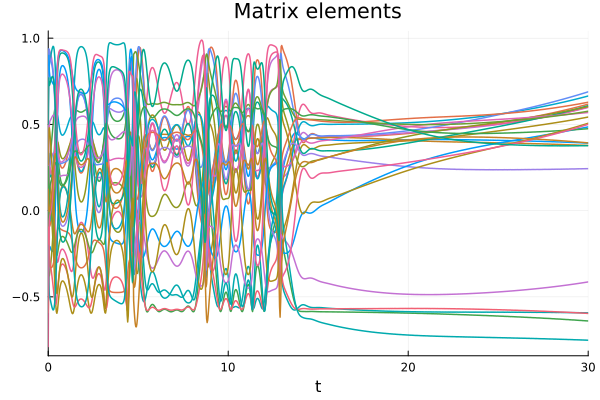

In [135]:
plot(sol, idxs=1:N^2, plotdensity=1000, lw=1.5, title="Matrix elements", legend=false)

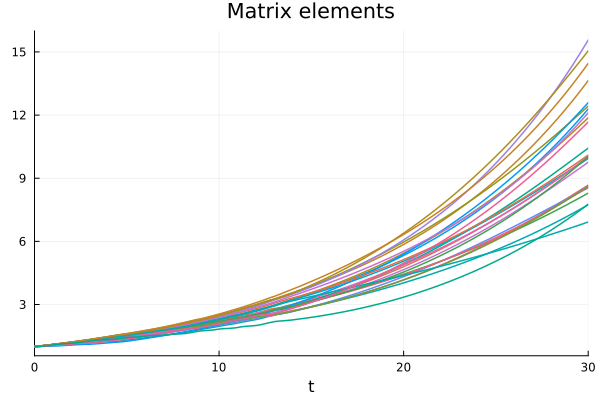

In [136]:
plot(sol, idxs=(N^2+1):(2*N^2), plotdensity=100, lw=1.5, title="Matrix elements", legend=false)
#plot(sol, idxs=101:110, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)

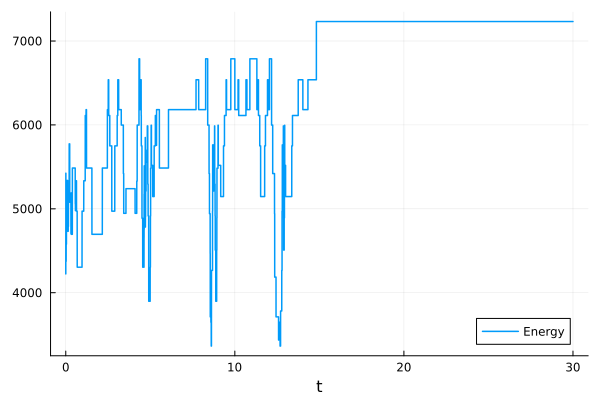

In [137]:
plot(sol.t,[ cost_fnc(reshape(x_t[1:N^2], N, N)) for x_t in sol.u] , label="Energy", lw=1.5, xlabel="t")

In [138]:
X = sol.u[end]
X = reshape(X[1:N^2], N, N)

X' * X


5×5 Matrix{Float64}:
  1.59701     0.589276    -0.0782745   0.183448  -0.146235
  0.589276    1.59064     -0.00640151  0.227628  -0.0962126
 -0.0782745  -0.00640151   1.65537     0.416311   0.479326
  0.183448    0.227628     0.416311    1.36014    0.272798
 -0.146235   -0.0962126    0.479326    0.272798   1.36842

In [139]:
P = (sign.(X).+1)/2

5×5 Matrix{Float64}:
 1.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  0.0
 0.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0

In [140]:
sum(P,dims=1)

1×5 Matrix{Float64}:
 4.0  4.0  4.0  4.0  4.0

In [141]:
sum(P,dims=2)

5×1 Matrix{Float64}:
 4.0
 4.0
 4.0
 4.0
 4.0